In [1]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers

import jax
import itertools
from functools import partial
from tqdm import trange

import skfmm
from scipy.stats.qmc import Halton
from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)
# import pandas as pd

onp.random.seed(1234)
random_key = random.PRNGKey(0)
jax.config.update("jax_default_device", jax.devices()[1])

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
plt.rcParams['font.size']=15

velocity_family1= onp.load('Style_A.npy')
velocity_family2= onp.load('FlatFault_A.npy')
velocity_family3= onp.load('Curvefault_A.npy')
velocity_family4= onp.load('Curvefault_B.npy')


num_velocity = 50
num_sources= 20
velocity_family = onp.concatenate((velocity_family1[:num_velocity,0,:,:],velocity_family2[:num_velocity,0,:,:],
                                   velocity_family3[:num_velocity,0,:,:],velocity_family4[:num_velocity,0,:,:]))
onp.random.shuffle(velocity_family)


velmodel = np.array(velocity_family)/1000


# grid range
z_min = 0.; z_max = 0.69; z_delta = 0.01;
x_min = 0.; x_max = 0.69; x_delta = 0.01;

grid_size = int(z_max/z_delta)+1
m = grid_size*grid_size


z = onp.arange(z_min,z_max+z_delta,z_delta)
x = onp.arange(x_min,x_max+x_delta,x_delta)

Z,X = jnp.meshgrid(z,x,indexing='ij')

coordinates = jnp.dstack((Z, X)).reshape(-1, 2)

gpu


In [2]:
def generate_random_points(num_sources, dimensions=2):
    
    # Create a Halton sequence sampler
    sampler = Halton(d=dimensions, seed=1234)
    
    # Generate points
    points = sampler.random(n=num_sources)
    
    # Scale the points to the grid size
    points *= (grid_size - 1)
    
    # Convert to integer indices
    points = np.round(points).astype(int)
    
    points = jnp.array(list(map(tuple, points)))
    
    return points

# Saves the randomly generated source locations
random_source_loc = generate_random_points(num_sources)

random_source_loc = random_source_loc.at[:,0].set(0)

print('location source',random_source_loc )

location source [[ 0 60]
 [ 0 14]
 [ 0 37]
 [ 0 67]
 [ 0 21]
 [ 0 44]
 [ 0 52]
 [ 0  6]
 [ 0 29]
 [ 0 55]
 [ 0  9]
 [ 0 32]
 [ 0 62]
 [ 0 16]
 [ 0 39]
 [ 0 47]
 [ 0  1]
 [ 0 24]
 [ 0 57]
 [ 0 11]]


In [3]:

def gen_data(grid_size=grid_size,
             num_sources=num_sources,
             num_velocity = num_velocity,
             # coordinates=coordinates,
             source=None,
             velocity_model= velmodel ,
             # V0 = V0,
             spacing=z_delta):

    V_all = []     # Holds all velocity model
    T0_all = []    # Holds all T0 
    # y_coord = []   # Holds all coordinates 
    Tau_all = []   # Holds all Tau values
    T_all = []     # Holds all T
    px_all = []
    pz_all = []
    s_point = []
    source_loc = source

    for k in range(num_velocity):
        for i in range(num_sources):
            
            sz = source_loc[i][0]
            sx = source_loc[i][1]
            
            V0_s=velocity_model[k, sz, sx]

            source_point = onp.ones((grid_size,grid_size)) * jnp.inf
            source_point[source_loc[i][0], source_loc[i][1]] = 0
            
            # Solve the travel time using the SKFMM
            T_data = skfmm.travel_time(source_point, velocity_model[k, :, :], dx=spacing, order=2)
            
            T0 = jnp.sqrt((Z-sz*z_delta)**2 + (X-sx*z_delta)**2)/V0_s

            Tau = T_data - T0
            
            px0 = onp.divide(X-(sx* z_delta)._value, T0*V0_s**2, out=onp.zeros_like(T0), where=T0!=0)
            pz0 = onp.divide(Z-(sz* z_delta)._value, T0*V0_s**2, out=onp.zeros_like(T0), where=T0!=0)
            
            # Appends dataset to defined list above
            V_all.append(velocity_model[k, :, :])
            T0_all.append(T0)
            Tau_all.append(Tau)
            T_all.append(T_data)
            px_all.append(px0)
            pz_all.append(pz0)
            s_point.append(jnp.array([sz,sx]))

    # Stacks data for all sources
    V_input = jnp.vstack(V_all).flatten().reshape(num_sources*num_velocity ,grid_size, grid_size,1)
    T0_input = jnp.vstack(T0_all).flatten().reshape(num_sources*num_velocity, grid_size, grid_size,1)
    Tau_input = jnp.vstack(Tau_all).flatten().reshape(num_sources*num_velocity, grid_size, grid_size,1)
    T_output = jnp.vstack(T_all).flatten().reshape(num_sources*num_velocity,grid_size, grid_size,1)
    px_output = jnp.vstack(px_all).flatten().reshape(num_sources*num_velocity,grid_size, grid_size)
    pz_output = jnp.vstack(pz_all).flatten().reshape(num_sources*num_velocity,grid_size, grid_size)
    s_point = jnp.array(s_point).reshape(num_sources*num_velocity, 2)

    return V_input, T0_input, Tau_input, T_output, px_output, pz_output, s_point

V_train, T0_train, Tau_train, T_train, px_train, pz_train, source_points = gen_data(num_sources=num_sources, source = random_source_loc)


In [4]:
import jax.numpy as jnp
from jax import random
from jax.example_libraries.optimizers import optimizer, make_schedule
from jax.example_libraries.stax import Gelu, serial
from jax.nn.initializers import glorot_uniform
from jax.flatten_util import ravel_pytree
import numpy as np
import timeit
     
@optimizer
def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
  """Construct optimizer triple for complex-valued Adam.

  Args:
    step_size: positive scalar, or a callable representing a step size schedule
      that maps the iteration index to positive scalar.
    b1: optional, a positive scalar value for beta_1, the exponential decay rate
      for the first moment estimates (default 0.9).
    b2: optional, a positive scalar value for beta_2, the exponential decay rate
      for the second moment estimates (default 0.999).
    eps: optional, a positive scalar value for epsilon, a small constant for
      numerical stability (default 1e-8).

  Returns:
    An (init_fun, update_fun, get_params) triple.
  """
  step_size = make_schedule(step_size)
  def init(x0):
    m0 = jnp.zeros_like(x0)
    v0 = jnp.zeros_like(x0)
    return x0, m0, v0
  def update(i, g, state):
    x, m, v = state
    g = jnp.conj(g) # <- conjugate
    m = (1 - b1) * g + b1 * m  # First  moment estimate.
    v = (1 - b2) * jnp.real(jnp.conj(g)* g) + b2 * v  # Second moment estimate.
    mhat = m / (1 - b1 ** (i + 1))  # Bias correction.
    vhat = v / (1 - b2 ** (i + 1))
    x = x - step_size(i) * mhat / (jnp.sqrt(vhat) + eps)
    return x, m, v
  def get_params(state):
    x, m, v = state
    return x
  return init, update, get_params


class DataGenerator():
    def __init__(self, T0, V, pz, px, targets, source_points,
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        # self.inputs = inputs
        self.T0 = T0
        self.V = V
        self.pz = pz
        self.px = px
        self.targets = targets
        self.source_points = source_points
        self.N = targets.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, T0, V, pz, px, targets, source_points):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        T0 = T0[idx,...]
        V = V[idx,...]
        pz = pz[idx,...]
        px = px[idx,...]
        targets = targets[idx,...]
        source_points = source_points[idx,...]
        return T0, V, pz, px, targets, source_points

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        T0, V, pz, px, targets, source_points = self.__data_generation(self.key, self.T0, self.V, self.pz, self.px, self.targets, self.source_points)
        return T0, V, pz, px, targets, source_points


def Permute(order):
    """Layer constructor function for a permutation layer."""
    def permutation_indices(order):
        if order=="ijkl->iljk":
            return (0,3,1,2)
        elif order=="ijkl->iklj":
            return (0,2,3,1)
        else:
              raise NotImplementedError
    def init_fun(rng, input_shape):
        idx = permutation_indices(order)
        output_shape = tuple([input_shape[i] for i in idx])
        return output_shape, ()
    def apply_fun(params, inputs, **kwargs):
        outputs = jnp.einsum(order, inputs)
        return outputs
    return init_fun, apply_fun

def SpectralConv2d(modes, W_init=glorot_uniform(dtype=jnp.complex64), b_init=None):
    """Layer constructor function for a SpectralConv2d layer."""
    def compl_mul2d(input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return jnp.einsum("bixy,ioxy->boxy", input, weights)
    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        output_shape = input_shape
        width = input_shape[1]
        W1 = W_init(k1, (width, width, modes, modes))
        W2 = W_init(k2, (width, width, modes, modes))
        return output_shape, (W1, W2)

    def apply_fun(params, inputs, **kwargs):
        W1, W2 = params
        batchsize = inputs.shape[0]
        _, out_channels, modes1, modes2 = W1.shape
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = jnp.fft.rfft2(inputs)
        # Multiply relevant Fourier modes
        out_ft = jnp.zeros((batchsize, out_channels,  inputs.shape[-2], inputs.shape[-1]//2 + 1), dtype=jnp.complex64)
        
        out_ft = out_ft.at[:, :, :modes1, :modes2].set(compl_mul2d(x_ft[:, :, :modes1, :modes2], W1))
        out_ft = out_ft.at[:, :, -modes1:, :modes2].set(compl_mul2d(x_ft[:, :, -modes1:, :modes2], W2))
        
        #Return to physical space
        out_ft = jnp.fft.irfft2(out_ft, s=(inputs.shape[-2], inputs.shape[-1]))
        return out_ft
    return init_fun, apply_fun


def FNOBlock2D(out_channels, modes):
    """Layer constructor function for a 2D FNO block."""
    conv_init, conv_apply = SpectralConv2d(modes)
    dense_init, dense_apply = Dense(out_channels)
    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        _, conv_params = conv_init(k1, input_shape)
        output_shape, dense_params = dense_init(k2, input_shape)
        return output_shape, (conv_params, dense_params)
    def apply_fun(params, inputs, **kwargs):
        conv_params, dense_params = params
        x1 = conv_apply(conv_params, inputs)
        x2 = dense_apply(dense_params, inputs)
        outputs = x1 + x2
        return outputs
    return init_fun, apply_fun

class LpLoss(object):
    def __init__(self, d=2, p=2):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p

    def rel(self, x, y):
        num_examples = x.shape[0]
        diff_norms = jnp.linalg.norm(y.reshape(num_examples,-1) - x.reshape(num_examples,-1), self.p, 1)
        y_norms = jnp.linalg.norm(y.reshape(num_examples,-1), self.p, 1)
        return jnp.mean(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

class FNO:
    def __init__(self, input_shape, layers, layers_branch1, layers_branch2):
        # Apply and init functions
        self.init, self.apply = serial(*layers) 
        self.init_branch1, self.apply_branch1 = serial(*layers_branch1) 
        self.init_branch2, self.apply_branch2 = serial(*layers_branch2) 
        
        _, params_FNO = self.init(random.PRNGKey(10000), input_shape)
        _, params_branch1 = self.init_branch1(random.PRNGKey(10000), input_shape)
        _, params_branch2 = self.init_branch2(random.PRNGKey(10000), input_shape)
        params = (params_FNO, params_branch1, params_branch2)

        # Relative L2 loss
        self.L2Loss = LpLoss()

        # Optimizer
        self.opt_init, self.opt_update, self.get_params = complex_adam(1e-4)
        self.opt_state = self.opt_init(params)
        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.ratio = 0.1

    def operator(self, params, T0, V):
        params_FNO, params_branch1, params_branch2 = params
        B1 = self.apply_branch1(params_branch1, T0)
        B2 = self.apply_branch2(params_branch2, V)

        outputs = self.apply(params_FNO,B1*B2)
        return outputs

    @partial(jit, static_argnums=0)
    def loss(self, params, batch):
        params_FNO, params_branch1, params_branch2 = params
        T0, V, pz, px, targets, source = batch
        
        outputs = self.operator(params, T0, V)
        loss = self.MSE(outputs, targets)
        return loss   
    @partial(jit, static_argnums=0)
    def loss_PINN(self, params, batch):
        # params_FNO, params_branch1, params_branch2 = params
        T0, V, pz, px, targets, source = batch
        
        tau = self.operator(params, T0, V)
        
        mask = jnp.where(T0<0.01,T0,1)
        mask = mask.at[:,0,:].set(0)
        
        tau = tau*mask[:,:,:,1,np.newaxis]

        dtau_dz = jnp.gradient(tau.reshape(-1, grid_size, grid_size), z_delta, axis=1)
        dtau_dx = jnp.gradient(tau.reshape(-1, grid_size, grid_size), x_delta, axis=2)
        term1 = dtau_dz + pz
        term2 = dtau_dx + px

        V = V[:,:,:,1].reshape(-1, grid_size, grid_size)
        
        pde = term1**2 +term2**2 - 1/ V**2
        
        loss = self.MSE(pde,jnp.zeros(pde.shape)) 
        return loss 

    
    def MSE(self, true,pred):
        return jnp.mean((true.flatten()-pred.flatten())**2)
    

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, f_weights, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_PINN)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, dataset, f_weights, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, f_weights, batch)
            # Logger
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_PINN(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])
    def predict(self, params, T0, V):
        params_FNO, params_branch1, params_branch2 = params
        outputs = self.operator(params, T0, V)
        return outputs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [19:10<00:00, 86.92it/s, Loss=0.00047902632]
/tmp/ipykernel_534574/126552214.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


The training wall-clock time is seconds is equal to 1150.434226 seconds


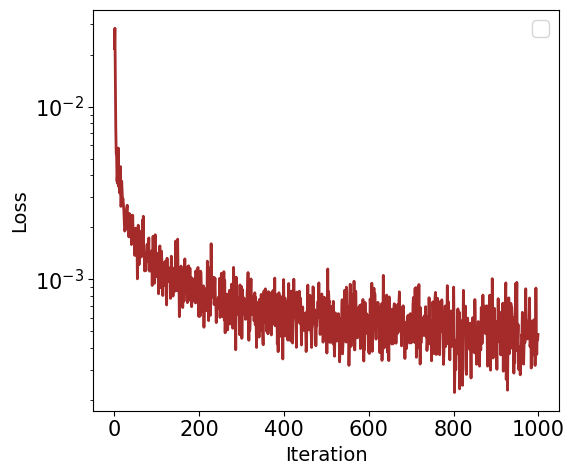

In [5]:
batch_size = 32

h = 70
width = 32
modes = 8

tile=3

y_train = Tau_train

f_weights = jnp.ones((num_sources*num_velocity,1))

x_train = jnp.tile(T0_train,(1,1,1,tile))
x_Vel_train = jnp.tile(V_train,(1,1,1,tile))
y_train = Tau_train

train_dataset = DataGenerator(x_train, x_Vel_train, pz_train, px_train,  y_train, source_points, batch_size)
train_dataset = iter(train_dataset)

# Specify the model architecture
input_shape = (-1, h, h, tile) # do not commit to a fixed batch size
layers = [Dense(width), 
          Permute("ijkl->iljk"), 
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes),
          Permute("ijkl->iklj"),
          Dense(128),
          Gelu,
          Dense(1)]

layers_cnn = [Conv(32,(5,5),(1,1),padding='same'),
              Gelu,
             Conv(32,(5,5),(1,1),padding='same'),
              Gelu,
              Conv(32,(5,5),(1,1),padding='same'),
              Gelu,
              Dense(1),
             ]

layers_branch1 = [Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(tile)
                  ]
layers_branch2 = [Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(tile)
                  ]

# Initialize the model class
model = FNO(input_shape, layers, layers_branch1, layers_branch2)
# model_cnn = FNO(input_shape, layers_cnn, layers_branch1, layers_branch2)

nIter = 100000

# Training
start_time = timeit.default_timer()
model.train(train_dataset, f_weights, nIter=nIter)

elapsed = timeit.default_timer() - start_time
print("The training wall-clock time is seconds is equal to %f seconds"%elapsed)

plt.figure(figsize = (6,5))
plt.plot(model.loss_log, lw=2,color='brown')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

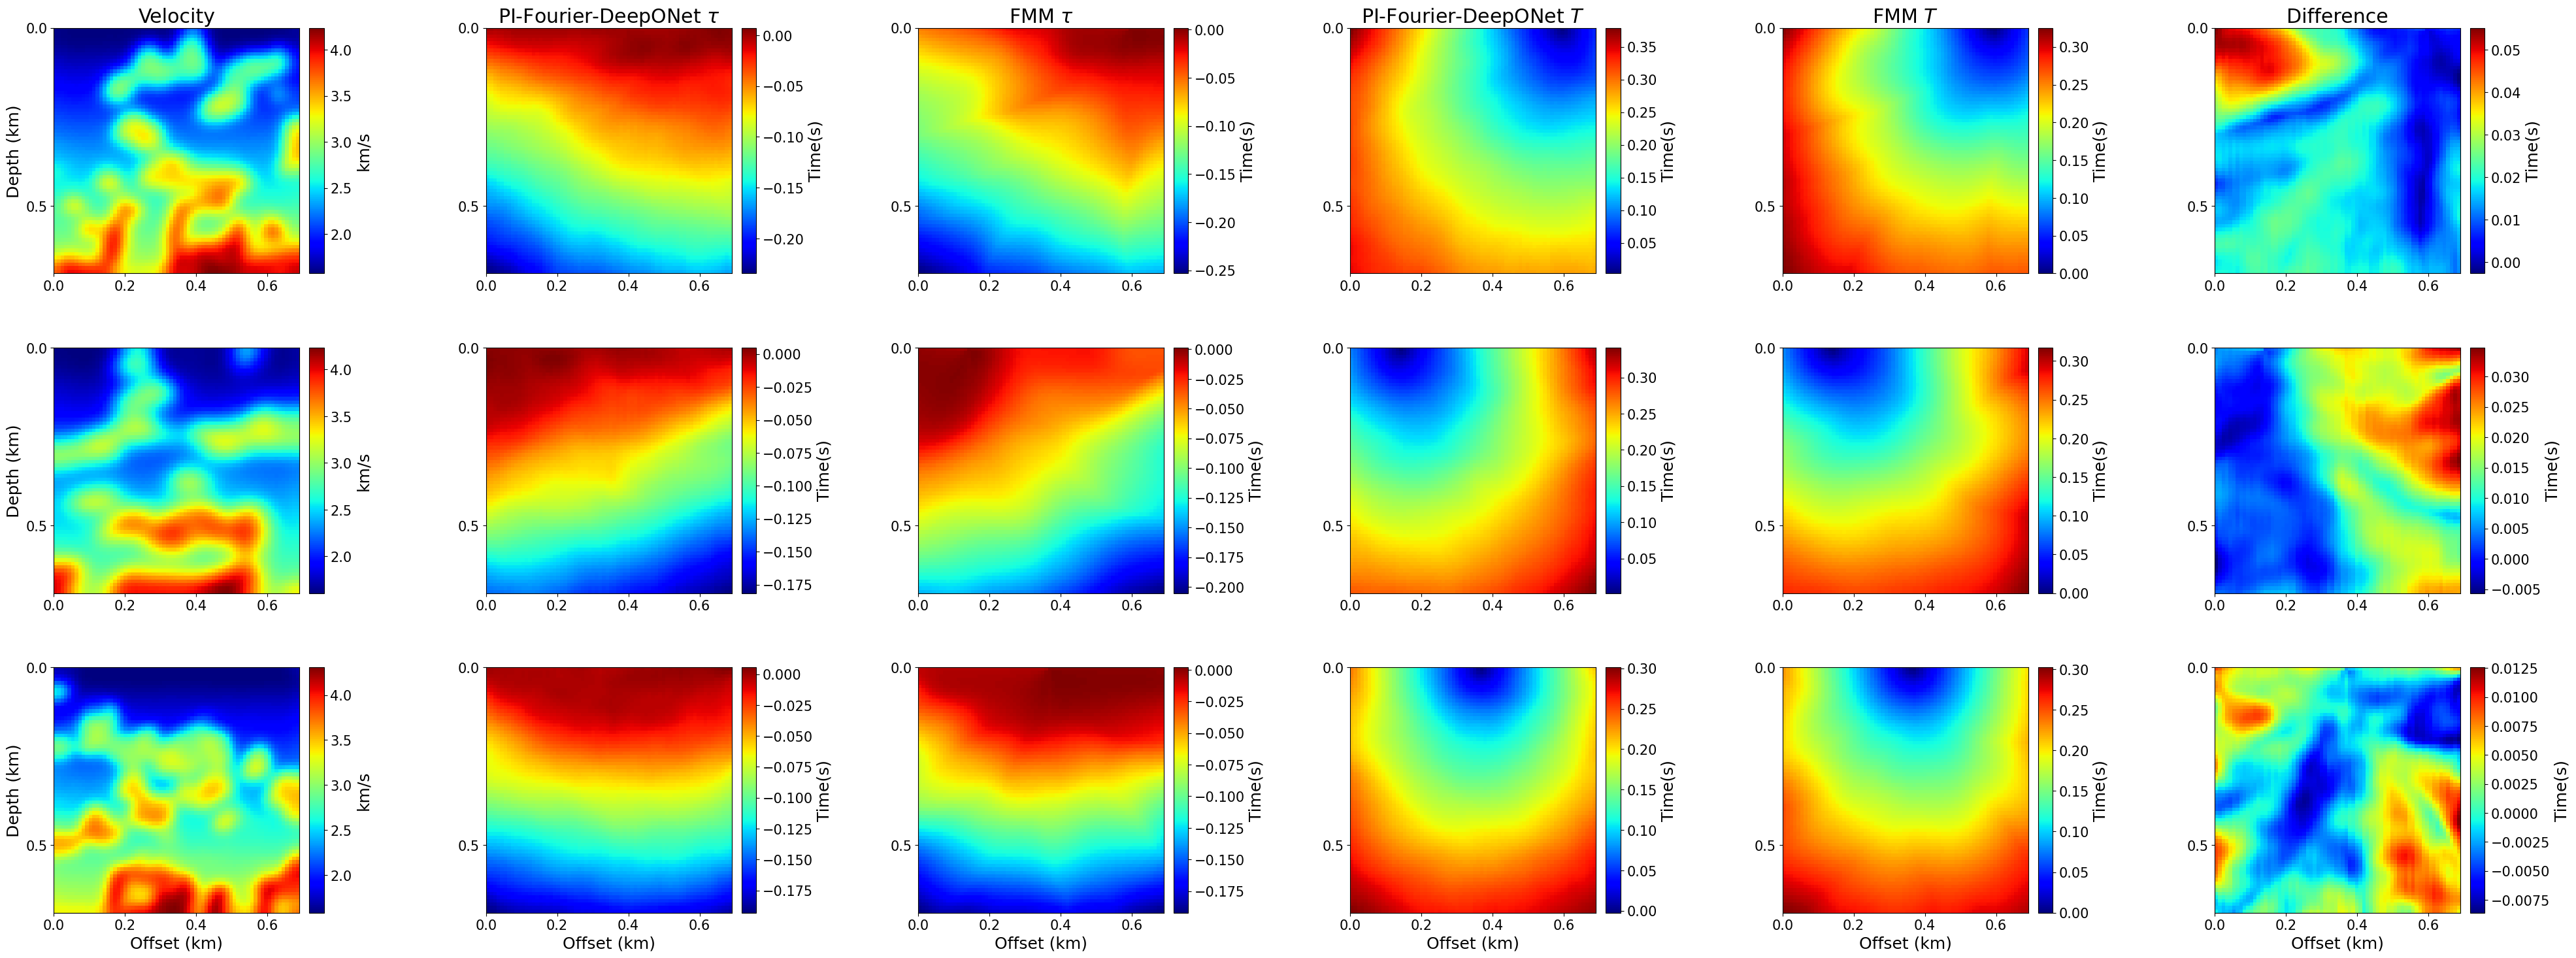

In [6]:
opt_params = model.get_params(model.opt_state)

source_test_1 = [random_source_loc[0]]
velmodel_test1 = velocity_family1[20]/1000
V_test_1, T0_test_1,  tau_test_1, T_test_1, px_test_1, pz_test_1, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test1, source = jnp.array(source_test_1))
T0_test1 = jnp.tile(T0_test_1, (1,1,1,tile))
V_test1 = jnp.tile(V_test_1, (1,1,1,tile))
tau_pred1 = model.predict(opt_params, T0_test1, V_test1)
T_pred1 = T0_test_1[0,:,:,0] + tau_pred1[0,:,:,0]

source_test_2 = [random_source_loc[1]]
velmodel_test2 = velocity_family1[21]/1000
V_test_2, T0_test_2, tau_test_2, T_test_2, px_test_2, pz_test_2, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test2, source = jnp.array(source_test_2))
T0_test2 = jnp.tile(T0_test_2, (1,1,1,tile))
V_test2 = jnp.tile(V_test_2, (1,1,1,tile))
tau_pred2 = model.predict(opt_params, T0_test2, V_test2)
T_pred2 = T0_test_2[0,:,:,0] + tau_pred2[0,:,:,0]

source_test_3 = [random_source_loc[2]]
velmodel_test3 = velocity_family1[22]/1000
V_test_3, T0_test_3, tau_test_3, T_test_3, px_test_3, pz_test_3, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test3, source = jnp.array(source_test_3))
T0_test3 = jnp.tile(T0_test_3, (1,1,1,tile))
V_test3 = jnp.tile(V_test_3, (1,1,1,tile))
tau_pred3 = model.predict(opt_params, T0_test3, V_test3)
T_pred3 = T0_test_3[0,:,:,0] + tau_pred3[0,:,:,0]



plt.rc('font', size=18) 
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)  

fig = plt.figure(figsize=(48,18))
ax1 = plt.subplot2grid((3,6), (0, 0))
ax2 = plt.subplot2grid((3,6), (0, 1))
ax3 = plt.subplot2grid((3,6), (0, 2))
ax4 = plt.subplot2grid((3,6), (0, 3))
ax5 = plt.subplot2grid((3,6), (0, 4))
ax6 = plt.subplot2grid((3,6), (0, 5))

pcm=ax1.imshow(velmodel_test1[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax1.set_ylabel("Depth (km)")
ax1.set_title('Velocity')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('km/s')

pcm=ax2.imshow(tau_pred1[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
# ax2.set_ylabel("Depth (km)")
# ax2.set_xlabel("Offset (km)")
ax2.set_title(r'PI-Fourier-DeepONet $\tau$')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax3.imshow(tau_test_1[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax3.set_title(r'FMM $\tau$')
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax4.imshow(T_pred1, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax4.set_title(r'PI-Fourier-DeepONet $T$')
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax5.imshow(T_test_1[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax5.set_title(r'FMM $T$')
ax5.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax6.imshow(tau_pred1[0,:,:,0]-tau_test_1[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax6.set_title(r'Difference')
ax6.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

ax21 = plt.subplot2grid((3,6), (1, 0))
ax22 = plt.subplot2grid((3,6), (1, 1))
ax23 = plt.subplot2grid((3,6), (1, 2))
ax24 = plt.subplot2grid((3,6), (1, 3))
ax25 = plt.subplot2grid((3,6), (1, 4))
ax26 = plt.subplot2grid((3,6), (1, 5))

pcm=ax21.imshow(velmodel_test2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax21.set_ylabel("Depth (km)")
ax21.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax21)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('km/s')

pcm=ax22.imshow(tau_pred2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax22.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax22)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax23.imshow(tau_test_2[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax23.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax23)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax24.imshow(T_pred2, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax24.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax24)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax25.imshow(T_test_2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax25.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax25)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax26.imshow(tau_pred2[0,:,:,0]-tau_test_2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax26.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax26)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')
ax31 = plt.subplot2grid((3,6), (2, 0))
ax32 = plt.subplot2grid((3,6), (2, 1))
ax33 = plt.subplot2grid((3,6), (2, 2))
ax34 = plt.subplot2grid((3,6), (2, 3))
ax35 = plt.subplot2grid((3,6), (2, 4))
ax36 = plt.subplot2grid((3,6), (2, 5))

pcm=ax31.imshow(velmodel_test3[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax31.set_ylabel("Depth (km)")
ax31.set_xlabel("Offset (km)")
ax31.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax31)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('km/s')

pcm=ax32.imshow(tau_pred3[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax32.set_xlabel("Offset (km)")
ax32.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax32)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax33.imshow(tau_test_3[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax33.set_xlabel("Offset (km)")
ax33.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax33)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax34.imshow(T_pred3, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax34.set_xlabel("Offset (km)")
ax34.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax34)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax35.imshow(T_test_3[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax35.set_xlabel("Offset (km)")
ax35.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax35)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

pcm=ax36.imshow(tau_pred3[0,:,:,0]-tau_test_3[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta , (grid_size-1)*z_delta, 0 ])
ax36.set_xlabel("Offset (km)")
ax36.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax36)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.set_ylabel('Time(s)')

fig.subplots_adjust(wspace=0.6)